# Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
# import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Read Data

In [ ]:
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas
data = pd.read_csv('/content/flight.csv', encoding = 'ISO-8859-1' )
data.head(66)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,210,505308,239560.0,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,140,362480,171483.0,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,135,351159,163618.0,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,23,337314,116350.0,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,152,273844,124560.0,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,29033,11/19/2004,11/19/2004,Male,6,HK,HK,HK,60.0,3/31/2014,77,169956,60120.0,91155.0,136121,3/31/2014,1,9.552632,55,4,1.288018,195217,7
62,16812,6/9/2010,6/27/2010,Male,6,PUCHONG,Selangor Darul Ehsan,MY,52.0,3/31/2014,84,182039,69796.0,118928.0,186821,3/26/2014,6,8.734940,69,1,0.938031,204668,2
63,5241,5/14/2011,5/14/2011,Male,6,hangzhoushi,zhejiang,CN,31.0,3/31/2014,96,165370,78243.0,65025.0,204612,3/18/2014,14,7.294737,55,12,0.848240,259585,81
64,49208,5/28/2010,10/16/2010,Male,6,beijing,beijing,CN,44.0,3/31/2014,30,188887,41590.0,81104.0,164001,3/24/2014,8,23.344828,128,2,1.057257,219035,16


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

# Data cleaning

## Data type

In [ ]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def find_invalid_date_rows(df):
    """Menemukan dan menampilkan baris dengan tanggal yang salah."""

    date_columns = [col for col in df.columns if col.endswith('_DATE')]
    invalid_rows = pd.DataFrame()

    for col in date_columns:
        try:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            invalid_rows = pd.concat([invalid_rows, df[(df[col].dt.month == 2) & (df[col].dt.day == 29) & (~df[col].dt.year.apply(is_leap)) | df[col].isnull()]])
        except (ValueError, TypeError) as e:
            print(f"Error converting '{col}': {e}")

    return invalid_rows.drop_duplicates()


# Contoh penggunaan:
invalid_rows = find_invalid_date_rows(data)
print("Baris dengan tanggal yang salah:")
print(invalid_rows)

Baris dengan tanggal yang salah:
       MEMBER_NO   FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER     WORK_CITY  \
248        56497 2007-06-17        2007-06-17  Female         6     guangzhou   
447        17306 2009-08-26        2010-04-29    Male         5       haerbin   
473          915 2006-11-10        2007-01-26    Male         5             .   
832        20336 2005-07-13        2005-08-06    Male         5     guangzhou   
1051       62884 2006-05-24        2007-04-21    Male         5         wuhan   
...          ...        ...               ...     ...       ...           ...   
61539      55995 2013-01-11        2013-07-10    Male         4     dalianshi   
61871      48742 2009-07-26        2009-07-26    Male         4       tianjin   
61909       9190 2011-04-11        2011-04-20    Male         4     guangzhou   
62721      38776 2007-10-31        2008-03-13    Male         4        foshan   
62929      46449 2010-02-07        2010-07-31    Male         4  guangzhoush

In [ ]:
data['FFP_DATE'] = pd.to_datetime(data['FFP_DATE'])
data['FIRST_FLIGHT_DATE'] = pd.to_datetime(data['FIRST_FLIGHT_DATE'])
data['LOAD_TIME'] = pd.to_datetime(data['LOAD_TIME'])
data['LAST_FLIGHT_DATE'] = pd.to_datetime(data['LAST_FLIGHT_DATE'], format='%m/%d/%Y %H:%M:%S')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          62988 non-null  int64         
 1   FFP_DATE           62988 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  62988 non-null  datetime64[ns]
 3   GENDER             62985 non-null  object        
 4   FFP_TIER           62988 non-null  int64         
 5   WORK_CITY          60719 non-null  object        
 6   WORK_PROVINCE      59740 non-null  object        
 7   WORK_COUNTRY       62962 non-null  object        
 8   AGE                62568 non-null  float64       
 9   LOAD_TIME          62988 non-null  datetime64[ns]
 10  FLIGHT_COUNT       62988 non-null  int64         
 11  BP_SUM             62988 non-null  int64         
 12  SUM_YR_1           62437 non-null  float64       
 13  SUM_YR_2           62850 non-null  float64       
 14  SEG_KM

## Missing value

In [ ]:
def clean_null_values(df):

    # Mengganti nilai kosong dengan NaN
    df.replace('', np.nan, inplace=True)
    df.replace(' ', np.nan, inplace=True)

    # Menghapus baris dengan setidaknya satu nilai NULL
    df.dropna(how='any', inplace=True)

    return df


data_cleaned = clean_null_values(data)
print(data_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 57860 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          57860 non-null  int64         
 1   FFP_DATE           57860 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  57860 non-null  datetime64[ns]
 3   GENDER             57860 non-null  object        
 4   FFP_TIER           57860 non-null  int64         
 5   WORK_CITY          57860 non-null  object        
 6   WORK_PROVINCE      57860 non-null  object        
 7   WORK_COUNTRY       57860 non-null  object        
 8   AGE                57860 non-null  float64       
 9   LOAD_TIME          57860 non-null  datetime64[ns]
 10  FLIGHT_COUNT       57860 non-null  int64         
 11  BP_SUM             57860 non-null  int64         
 12  SUM_YR_1           57860 non-null  float64       
 13  SUM_YR_2           57860 non-null  float64       
 14  SEG_KM_SUM 

# Segmentasi Pelanggan dengan RFM

Tujuan:
- Memahami perilaku pelanggan berdasarkan hubungan mereka dengan bisnis.
- Mengidentifikasi pelanggan loyal, potensial churn, atau bernilai tinggi.
Fitur Relevan:
1. Recency (R)
- Kolom yang Digunakan: LAST_FLIGHT_DATE dan LOAD_TIME
- Alasan: Recency mencerminkan seberapa baru interaksi pelanggan terakhir dengan layanan maskapai. Dalam konteks ini, penerbangan terakhir adalah interaksi terbaru dengan program frequent flyer. Selisih antara LOAD_TIME (waktu data diambil) dan LAST_FLIGHT_DATE memberikan informasi seberapa "baru" pelanggan tersebut, yang dapat memengaruhi loyalitas mereka terhadap layanan maskapai.
2. Frequency (F)
- Kolom yang Digunakan: FLIGHT_COUNT
- Alasan: Kolom ini mencatat jumlah penerbangan yang telah dilakukan oleh pelanggan. Ini memberikan gambaran tentang seberapa sering pelanggan berinteraksi dengan layanan. Pelanggan yang sering terbang menunjukkan loyalitas dan kemungkinan untuk terus menggunakan layanan di masa depan.
3. Monetary (M)
- Kolom yang Digunakan: SUM_YR_1 dan SUM_YR_2
- Alasan:Kolom ini mencerminkan pendapatan yang dihasilkan dari pelanggan selama dua periode waktu tertentu. Pendapatan ini secara langsung menunjukkan kontribusi finansial pelanggan terhadap maskapai.

In [ ]:
# Recency
data['Recency'] = (data['LOAD_TIME'] - data['LAST_FLIGHT_DATE']).dt.days

In [ ]:
# Frecuency
data['Frequency'] = data['FLIGHT_COUNT']

In [ ]:
# Monetery
data['Monetary'] = data['SUM_YR_1'] + data['SUM_YR_2']

In [ ]:
rfm_df = data[['MEMBER_NO', 'Recency', 'Frequency', 'Monetary']]
rfm_df.head()

,MEMBER_NO,Recency,Frequency,Monetary
0,54993,0,210,473748.0
2,55106,10,135,328600.0
3,21189,95,23,241850.0
4,39546,4,152,255262.0
5,56972,77,92,189310.0


In [ ]:
df = rfm_df.copy()

In [ ]:
# Menghitung persentil
df['recency_percentile'] = df['Recency'].rank(pct=True, ascending=False)
df['frequency_percentile'] = df['Frequency'].rank(pct=True, ascending=True)
df['monetary_percentile'] = df['Monetary'].rank(pct=True, ascending=True)

In [ ]:
def assign_score(percentile):
    if percentile >= 0.8:
        return 5
    elif percentile >= 0.6:
        return 4
    elif percentile >= 0.4:
        return 3
    elif percentile >= 0.2:
        return 2
    else:
        return 1

# Menerapkan skor RFM
df['recency_score'] = df['recency_percentile'].apply(assign_score)
df['frequency_score'] = df['frequency_percentile'].apply(assign_score)
df['monetary_score'] = df['monetary_percentile'].apply(assign_score)

In [ ]:
# Menghitung total skor RFM
df['RFM_Score'] = df['recency_score'] + df['frequency_score'] + df['monetary_score']

# Menampilkan hasil segmentasi
df.head(10)

,MEMBER_NO,Recency,Frequency,Monetary,recency_percentile,frequency_percentile,monetary_percentile,recency_score,frequency_score,monetary_score,RFM_Score
0,54993,0,210,473748.0,0.992102,0.999983,1.000000,5,5,5,15
2,55106,10,135,328600.0,0.873047,0.999620,0.999965,5,5,5,15
3,21189,95,23,241850.0,0.521085,0.862262,0.999914,3,5,5,13
4,39546,4,152,255262.0,0.934419,0.999810,0.999931,5,5,5,15
5,56972,77,92,189310.0,0.565330,0.996405,0.999723,3,5,5,13
6,44924,0,101,234969.0,0.992102,0.997770,0.999896,5,5,5,15
7,22631,2,73,197411.0,0.962297,0.990987,0.999793,5,5,5,15
9,31645,14,64,145525.0,0.835292,0.985793,0.998928,5,5,5,15
10,58877,21,43,160637.0,0.785620,0.958486,0.999240,4,5,5,14
11,37994,5,145,219796.0,0.922174,0.999723,0.999844,5,5,5,15


In [ ]:
def segment_customer(row):
    if row['Recency'] <= 30 and row['Frequency'] > 5 and row['Monetary'] > 1000:
        return 'Pelanggan Setia'
    elif row['Recency'] <= 30 and row['Frequency'] <= 5:
        return 'Pelanggan Baru'
    elif row['Recency'] > 30 and row['Frequency'] > 5:
        return 'Pelanggan Potensial'
    else:
        return 'Pelanggan Berisiko'

rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

In [ ]:
print(rfm_df.groupby('Segment').mean())

                        MEMBER_NO     Recency  Frequency      Monetary
Segment                                                               
Pelanggan Baru       31184.079983   13.687500   3.430070   3256.073427
Pelanggan Berisiko   31344.327877  301.950940   3.140788   2987.367281
Pelanggan Potensial  31723.558878  151.178530  13.429599  12230.782332
Pelanggan Setia      31651.683063   11.753225  25.984987  23762.255149


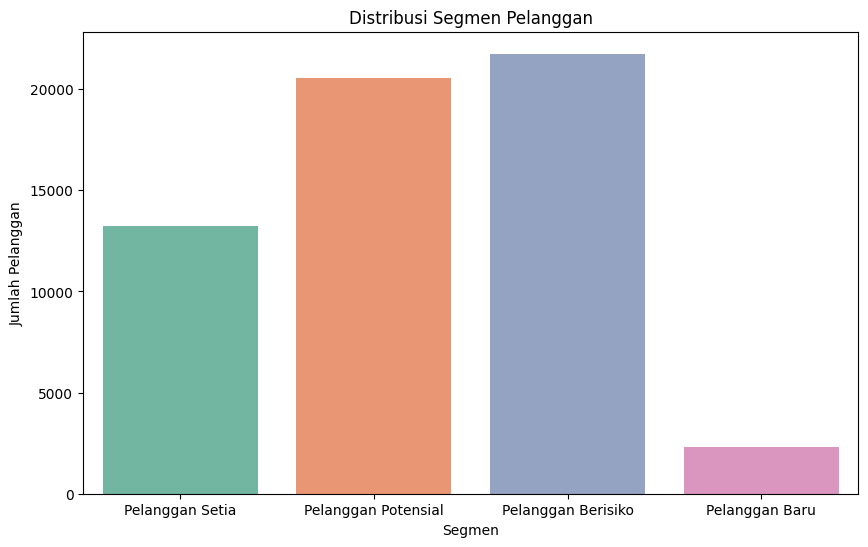

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_df, x='Segment', palette='Set2')
plt.title('Distribusi Segmen Pelanggan')
plt.xlabel('Segmen')
plt.ylabel('Jumlah Pelanggan')
plt.show()

## Segmentasi dengan kmeans

In [ ]:
# Selecting RFM Features
rfm_features = ['Recency', 'Frequency', 'Monetary']
rfm_data = data[rfm_features].values

# Scaling
scaler = StandardScaler()
rfm_data_scaled = scaler.fit_transform(rfm_data)
rfm_df = pd.DataFrame(data = rfm_data_scaled, columns = rfm_features)
rfm_df.head()

,Recency,Frequency,Monetary
0,-0.944097,13.902061,30.142424
1,-0.888716,8.634985,20.686910
2,-0.417983,0.769485,15.035673
3,-0.921945,9.828855,15.909383
4,-0.517668,5.615194,11.613010


In [ ]:
# # Scaling
# scaler = StandardScaler()
# rfm_data_scaled = scaler.fit_transform(rfm_data)

In [ ]:
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(rfm_data_scaled)
  nilai_intertia = kmeans.inertia_
  inertia.append(nilai_intertia)
  print('cluster ke -',i,'nilai intertia : ',nilai_intertia)

cluster ke - 1 nilai intertia :  173579.99999999886
cluster ke - 2 nilai intertia :  102549.89942215262
cluster ke - 3 nilai intertia :  60145.879103611675
cluster ke - 4 nilai intertia :  42138.33207841119
cluster ke - 5 nilai intertia :  35058.54537809614
cluster ke - 6 nilai intertia :  28136.734842511032
cluster ke - 7 nilai intertia :  25625.001781416155
cluster ke - 8 nilai intertia :  21909.23316077389
cluster ke - 9 nilai intertia :  20466.481464436347
cluster ke - 10 nilai intertia :  18097.96701712679


<Axes: >

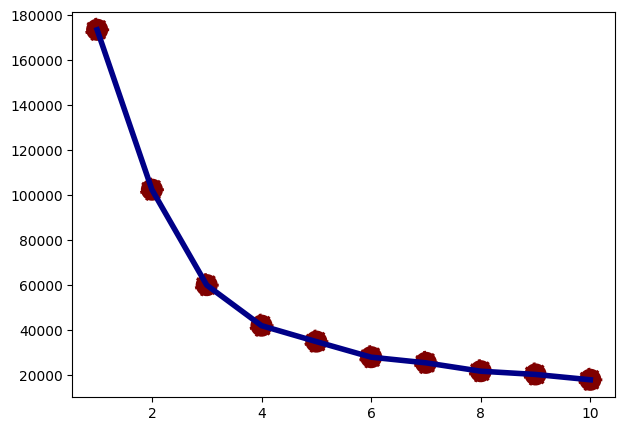

In [ ]:
plt.figure(figsize=(7, 5))

sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 11), y=inertia, s=300, color='#800000',  linestyle='--')

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
print(range_n_clusters)
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(rfm_df)
    preds = kmeans.predict(rfm_df)
    score_euclidean = silhouette_score(rfm_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


<Axes: >

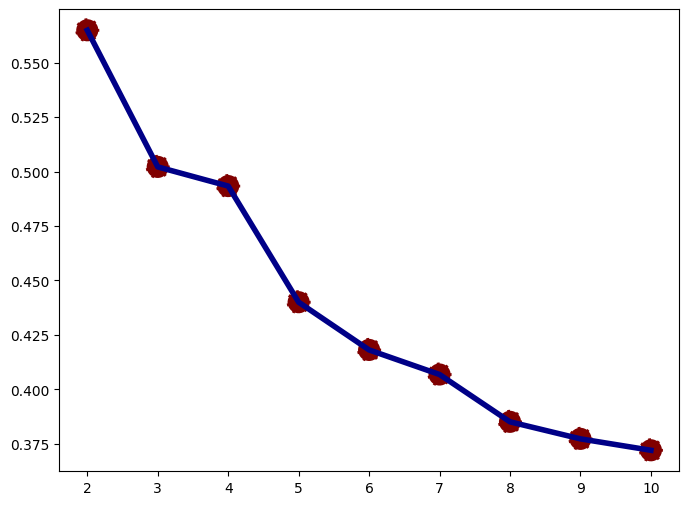

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

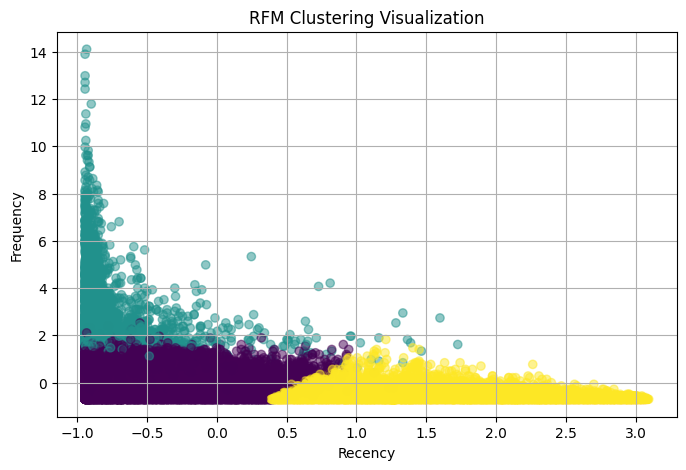

Cluster Centers:
      Recency  Frequency      Monetary
0   87.959562  10.257058   8820.102546
1   26.970163  46.666287  47177.491258
2  443.228211   4.103751   3715.225770


In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(rfm_data_scaled)

# Visualize Clusters
plt.figure(figsize=(8, 5))
plt.scatter(rfm_data_scaled[:, 0], rfm_data_scaled[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('RFM Clustering Visualization')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Analyze Cluster Centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:")
print(pd.DataFrame(centers, columns=rfm_features))


## **Interpretasi Hasil Clustering**

### **Cluster 0 (Purple):**
- **Recency:** 87.96
  - Pelanggan di cluster ini rata-rata terakhir kali menggunakan layanan sekitar **88 hari yang lalu**.
  - **Makna:** Cluster ini berisi pelanggan yang cukup aktif karena jarak waktu sejak interaksi terakhir relatif singkat.
  - **Strategi:** Fokus pada mempertahankan pelanggan ini melalui program loyalitas atau penghargaan atas penggunaan reguler mereka.
- **Frequency:** 10.26
  - Rata-rata pelanggan dalam cluster ini telah terbang **10 kali**.
  - **Makna:** Cluster ini mencerminkan pelanggan dengan frekuensi perjalanan moderat.
  - **Strategi:** Meningkatkan keterlibatan pelanggan dengan penawaran promosi.
- **Monetary:** 8820.10
  - Rata-rata pengeluaran atau poin pelanggan adalah **8.820**.
  - **Makna:** Pelanggan memiliki nilai finansial yang signifikan tetapi tidak luar biasa tinggi.
  - **Strategi:** Dorong mereka untuk meningkatkan nilai transaksi dengan penawaran khusus.

---

### **Cluster 1 (Cyan):**
- **Recency:** 26.97
  - Pelanggan di cluster ini terakhir kali menggunakan layanan sekitar **27 hari yang lalu**.
  - **Makna:** Cluster ini sangat aktif dan sering menggunakan layanan.
  - **Strategi:** Lakukan retensi aktif dengan memberikan pengalaman terbaik dan program khusus VIP.
- **Frequency:** 46.67
  - Rata-rata pelanggan telah terbang **47 kali**.
  - **Makna:** Cluster ini mencerminkan pengguna intensif dengan frekuensi tinggi.
  - **Strategi:** Manfaatkan pelanggan ini untuk memperkuat brand loyalty dengan layanan premium atau eksklusif.
- **Monetary:** 47,177.49
  - Rata-rata pengeluaran atau poin pelanggan adalah **47.177**.
  - **Makna:** Ini adalah pelanggan bernilai tinggi dengan kontribusi signifikan terhadap bisnis.
  - **Strategi:** Pertahankan pelanggan ini melalui program eksklusif, seperti membership premium.

---

### **Cluster 2 (Yellow):**
- **Recency:** 443.23
  - Pelanggan di cluster ini rata-rata terakhir kali menggunakan layanan sekitar **443 hari yang lalu**.
  - **Makna:** Cluster ini terdiri dari pelanggan yang sudah cukup lama tidak aktif.
  - **Strategi:** Lakukan reaktivasi pelanggan dengan penawaran menarik.
- **Frequency:** 4.10
  - Rata-rata pelanggan dalam cluster ini hanya terbang **4 kali**.
  - **Makna:** Frekuensi penggunaan layanan rendah.
  - **Strategi:** Edukasi pelanggan tentang manfaat layanan dan penawaran.
- **Monetary:** 3,715.23
  - Rata-rata pengeluaran atau poin pelanggan adalah **3.715**.
  - **Makna:** Pelanggan ini memiliki nilai finansial yang rendah.
  - **Strategi:** Lakukan upaya promosi untuk meningkatkan nilai kontribusi mereka.

---

## **Kesimpulan**
- **Cluster 0 (Purple):** Pelanggan aktif dengan kontribusi sedang, memerlukan program peningkatan keterlibatan.
- **Cluster 1 (Cyan):** Pelanggan bernilai tinggi dan sangat aktif, perlu dijaga loyalitasnya.
- **Cluster 2 (Yellow):** Pelanggan tidak aktif dengan kontribusi rendah, membutuhkan strategi reaktivasi.


# Segmentasi pelanggan Berdasarkan Loyalitas
Tujuan:
- Mengelompokkan pelanggan berdasarkan tingkat loyalitas terhadap maskapai.
- Mengidentifikasi pelanggan paling aktif dalam program loyalitas.

Fitur Relevan:
- FFP_TIER: Tingkat keanggotaan frequent flyer program.
- Points_Sum: Total poin yang dikumpulkan.
- EXCHANGE_COUNT: Jumlah pertukaran poin.
- Recency: Seberapa baru mereka terbang.

In [ ]:
# Selecting Features
features = ['Recency','FFP_TIER', 'Points_Sum', 'EXCHANGE_COUNT']
loyal_data = data[features].values

# Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(loyal_data)
new_df = pd.DataFrame(data = data_scaled, columns = features)
new_df.head()

,Recency,FFP_TIER,Points_Sum,EXCHANGE_COUNT
0,-0.944097,5.011422,29.437281,29.286323
1,-0.888716,5.011422,19.088868,17.109788
2,-0.417983,2.367337,17.432484,9.282015
3,-0.921945,5.011422,15.813245,23.198055
4,-0.517668,5.011422,16.022154,8.412262


In [ ]:
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(data_scaled)
  nilai_intertia = kmeans.inertia_
  inertia.append(nilai_intertia)
  print('cluster ke -',i,'nilai intertia : ',nilai_intertia)

cluster ke - 1 nilai intertia :  231439.99999999927
cluster ke - 2 nilai intertia :  151423.01635598563
cluster ke - 3 nilai intertia :  126509.2387233963
cluster ke - 4 nilai intertia :  84439.33522781974
cluster ke - 5 nilai intertia :  69630.97152024542
cluster ke - 6 nilai intertia :  63889.05704999769
cluster ke - 7 nilai intertia :  56586.17114103139
cluster ke - 8 nilai intertia :  49484.796813613495
cluster ke - 9 nilai intertia :  46055.19748116292
cluster ke - 10 nilai intertia :  43161.43950924102


<Axes: >

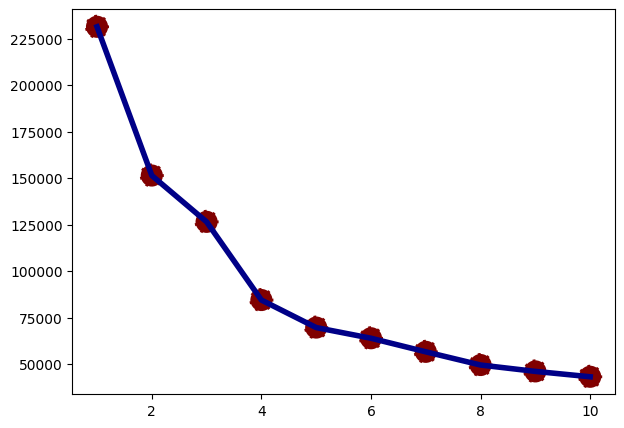

In [ ]:
plt.figure(figsize=(7, 5))

sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 11), y=inertia, s=300, color='#800000',  linestyle='--')

In [ ]:
range_n_clusters = list(range(2,11))
print(range_n_clusters)
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(new_df)
    preds = kmeans.predict(new_df)
    score_euclidean = silhouette_score(new_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


<Axes: >

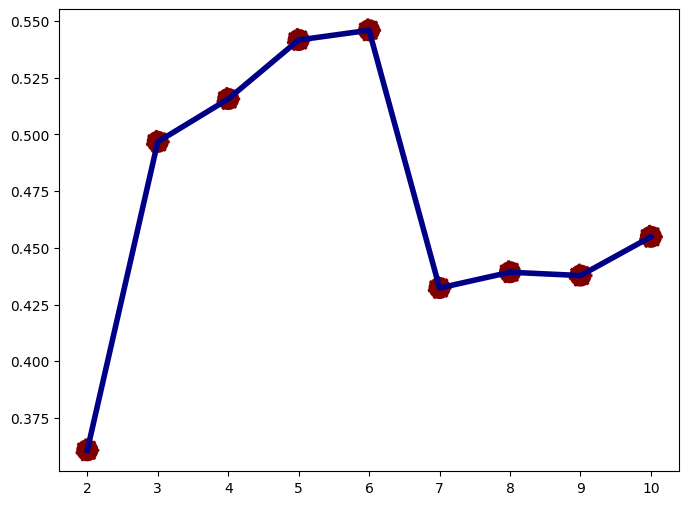

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

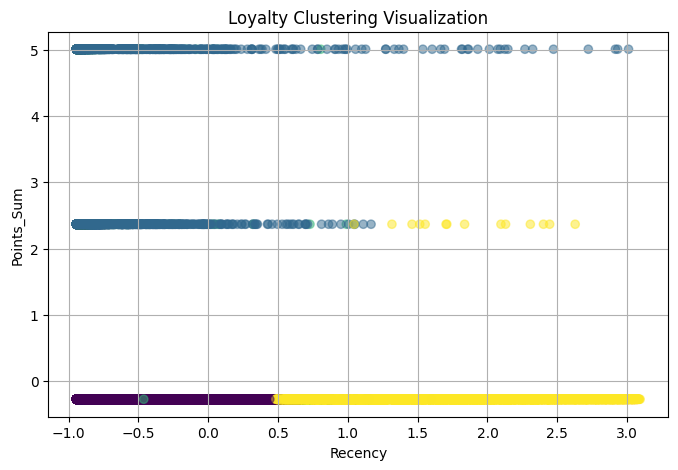

Cluster Centers:
      Recency  FFP_TIER    Points_Sum  EXCHANGE_COUNT
0   88.576378  4.000000  10866.672317        0.231821
1   34.439873  5.269515  38120.279800        0.691983
2   26.878871  5.118397  97764.500911        5.992714
3  448.765919  4.001006   4294.389176        0.051675


In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualize Clusters
plt.figure(figsize=(8, 5))
plt.scatter(data_scaled[:, 0],data_scaled[:, 1], c=data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Loyalty Clustering Visualization')
plt.xlabel('Recency')
plt.ylabel('Points_Sum')
plt.grid()
plt.show()

# Analyze Cluster Centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:")
print(pd.DataFrame(centers, columns=features))

## Interpretasi Hasil Clustering
---

### **Cluster 0 :**
- **Recency:** 88.58
  - Rata-rata pelanggan terakhir kali menggunakan layanan sekitar **89 hari yang lalu**.
  - **Makna:** Pelanggan ini cukup aktif, dengan jarak waktu interaksi terakhir yang moderat.
- **FFP_TIER:** 4.00
  - Frequent flyer tier mereka cukup rendah.
  - **Makna:** Keterlibatan dalam program loyalitas tidak signifikan.
- **Points_Sum:** 10,866.67
  - Rata-rata poin pelanggan adalah **10,867**.
  - **Makna:** Mereka adalah pelanggan dengan keterlibatan moderat.
- **EXCHANGE_COUNT:** 0.23
  - Aktivitas pertukaran poin sangat rendah.
  - **Makna:** Mereka jarang memanfaatkan program loyalitas meskipun memiliki poin yang layak.
- **Kesimpulan:**
  - **Pelanggan tidak aktif dengan nilai moderat:** Pelanggan ini pernah aktif tetapi kontribusi mereka rendah.
  - **Strategi:** Fokus pada reaktivasi melalui promosi berbasis loyalitas.

---

### **Cluster 1:**
- **Recency:** 34.43
  - Rata-rata pelanggan terakhir kali menggunakan layanan sekitar **34 hari yang lalu**.
  - **Makna:** Pelanggan cukup aktif, dengan jarak waktu interaksi terakhir yang pendek.
- **FFP_TIER:** 5.27
  - Tier frequent flyer yang tinggi.
  - **Makna:** Mereka adalah pelanggan setia dengan keterlibatan yang tinggi.
- **Points_Sum:** 38,120.28
  - Poin rata-rata cukup besar, sekitar **38,120**.
  - **Makna:** Mereka adalah pelanggan bernilai tinggi, meskipun tidak setinggi Cluster 1.
- **EXCHANGE_COUNT:** 0.69
  - Aktivitas pertukaran poin sedang.
  - **Makna:** Mereka cukup aktif memanfaatkan program loyalitas.
- **Kesimpulan:**
  - **Pelanggan loyal dengan nilai tinggi:** Pelanggan ini aktif dan memiliki kontribusi besar.
  - **Strategi:** Retensi dengan program loyalitas yang ditingkatkan, seperti diskon eksklusif atau penghargaan berbasis poin.

---

### **Cluster 2 :**
- **Recency:** 26.88
  - Rata-rata pelanggan terakhir kali menggunakan layanan sekitar **27 hari yang lalu**.
  - **Makna:** Pelanggan ini sangat aktif, dengan jarak waktu interaksi yang sangat singkat.
- **FFP_TIER:** 5.11
  - Tier frequent flyer mereka sangat tinggi.
  - **Makna:** Mereka adalah pelanggan yang sangat loyal dan sering bepergian.
- **Points_Sum:** 97,764.50
  - Poin rata-rata yang sangat besar, sekitar **97,765**.
  - **Makna:** Pelanggan ini memiliki kontribusi finansial tertinggi.
- **EXCHANGE_COUNT:** 5.99
  - Aktivitas pertukaran poin sangat tinggi.
  - **Makna:** Mereka memanfaatkan program loyalitas secara maksimal.
- **Kesimpulan:**
  - **Pelanggan bernilai tinggi yang sangat loyal:** Ini adalah pelanggan yang memberikan kontribusi besar terhadap bisnis.
  - **Strategi:** Fokus pada program eksklusif seperti penghargaan premium dan diskon besar untuk menjaga loyalitas mereka.

---

### **Cluster 3 :**
- **Recency:** 448.77
  - Rata-rata pelanggan terakhir kali menggunakan layanan sekitar **449 hari yang lalu**.
  - **Makna:** Pelanggan ini sudah lama tidak aktif menggunakan layanan.
- **FFP_TIER:** 0.00
  - Tier frequent flyer hampir tidak ada.
  - **Makna:** Mereka bukan pengguna program loyalitas yang signifikan.
- **Points_Sum:** 4,294.39
  - Poin rata-rata sangat rendah, hanya **4,294**.
  - **Makna:** Mereka adalah pelanggan dengan aktivitas sangat rendah.
- **EXCHANGE_COUNT:** 0.05
  - Aktivitas pertukaran poin hampir tidak ada.
  - **Makna:** Mereka tidak memanfaatkan program loyalitas.
- **Kesimpulan:**
  - **Pelanggan tidak aktif dengan nilai rendah:** Pelanggan jarang menggunakan layanan dan tidak menunjukkan keterlibatan loyalitas.
  - **Strategi:** Prioritas rendah untuk retensi, tetapi promosi besar-besaran dapat dilakukan untuk mencoba menarik mereka kembali.

---

## **Analisis Keseluruhan:**
1. **Cluster 2 (Bernilai Tinggi dan Loyal):**
   - Pelanggan ini adalah yang paling aktif dan bernilai tinggi. Mereka adalah prioritas utama untuk retensi.
2. **Cluster 1 (Loyal dengan Nilai Tinggi):**
   - Pelanggan setia dengan kontribusi besar. Retensi melalui penghargaan berbasis loyalitas akan efektif.
3. **Cluster 0 (Tidak Aktif dengan Nilai Moderat):**
   - Pelanggan yang tidak aktif tetapi memiliki potensi nilai. Strategi reaktivasi dapat diterapkan.
4. **Cluster 3 (Yellow - Tidak Aktif dengan Nilai Rendah):**
   - Pelanggan yang jarang terlibat dan bernilai rendah. Prioritas rendah, tetapi dapat ditargetkan dengan promosi besar-besaran.


# Segmentasi Berdasarkan Preferensi Promosi
Tujuan:
- Mengelompokkan pelanggan berdasarkan respons mereka terhadap promosi.
- Membantu menciptakan kampanye pemasaran yang lebih terarah.

Fitur Relevan:
- avg_discount: Rata-rata diskon yang diterima.
- Points_Sum: Total poin yang dimiliki pelanggan.
- EXCHANGE_COUNT: Indikator partisipasi dalam program promosi.
- Monetary: Total pengeluaran.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Select relevant features
features = ['avg_discount', 'Points_Sum', 'EXCHANGE_COUNT', 'Monetary']
promo_data = data[features].values

# Scaling
scaler = StandardScaler()
promo_data_scaled = scaler.fit_transform(promo_data)
promo_df = pd.DataFrame(data = promo_data_scaled, columns = features)
promo_df.head()


,avg_discount,Points_Sum,EXCHANGE_COUNT,Monetary
0,1.310280,29.437281,29.286323,30.142424
1,2.903386,19.088868,17.109788,20.686910
2,2.012847,17.432484,9.282015,15.035673
3,1.359311,15.813245,23.198055,15.909383
4,1.343190,16.022154,8.412262,11.613010


In [ ]:
# Determine optimal number of clusters (Elbow Method)
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(promo_data_scaled)
  nilai_intertia = kmeans.inertia_
  inertia.append(nilai_intertia)
  print('cluster ke -',i,'nilai intertia : ',nilai_intertia)

cluster ke - 1 nilai intertia :  231440.00000000434
cluster ke - 2 nilai intertia :  151281.88125687244
cluster ke - 3 nilai intertia :  122203.77260165989
cluster ke - 4 nilai intertia :  99162.19266769866
cluster ke - 5 nilai intertia :  87792.12546804459
cluster ke - 6 nilai intertia :  77692.17175253035
cluster ke - 7 nilai intertia :  67057.35868898092
cluster ke - 8 nilai intertia :  61334.96873613216
cluster ke - 9 nilai intertia :  55203.082521909026
cluster ke - 10 nilai intertia :  50251.730613552805


<Axes: >

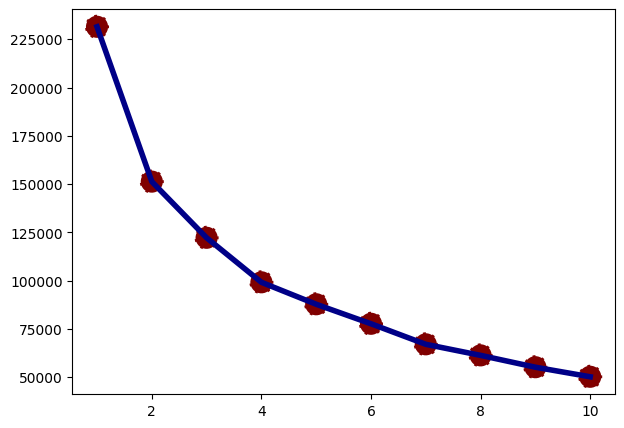

In [ ]:
# Plot Elbow Method
plt.figure(figsize=(7, 5))

sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 11), y=inertia, s=300, color='#800000',  linestyle='--')

In [ ]:
range_n_clusters = list(range(2,11))
print(range_n_clusters)
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(promo_df)
    preds = kmeans.predict(promo_df)
    score_euclidean = silhouette_score(promo_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


<Axes: >

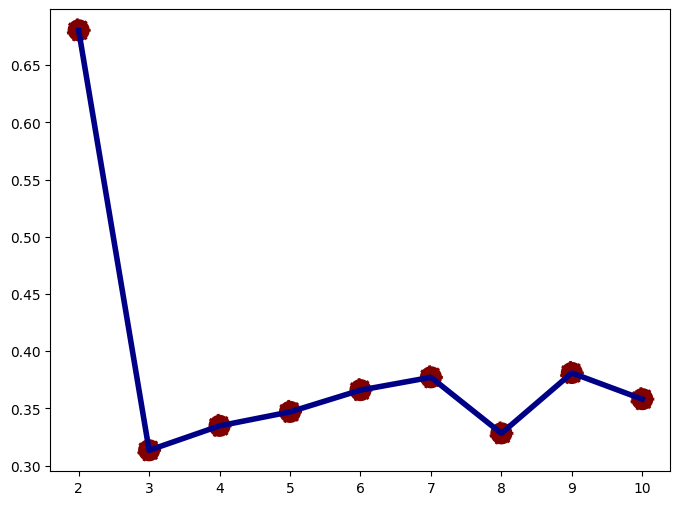

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

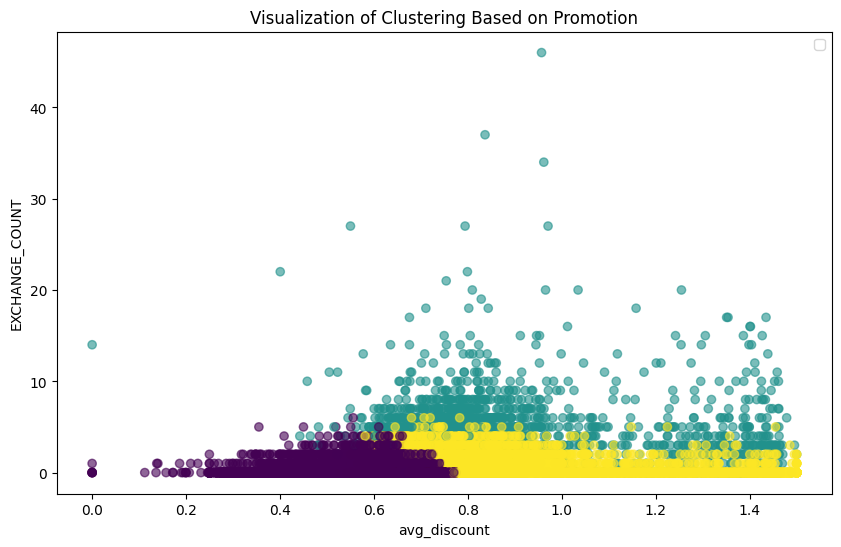

Cluster Centers:
   avg_discount    Points_Sum  EXCHANGE_COUNT      Monetary
0      0.595180   5481.052496        0.083064   5313.571493
1      0.864723  74152.959380        3.418589  57410.085026
2      0.842951  13877.502372        0.254534  12207.653976


In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
data['Cluster'] = kmeans.fit_predict(promo_data_scaled)

# Visualize Clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['avg_discount'], data['EXCHANGE_COUNT'], c=data['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('avg_discount')
plt.ylabel('EXCHANGE_COUNT')
plt.title('Visualization of Clustering Based on Promotion')
plt.legend()
plt.show()

# Analyze Cluster Centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers:")
print(pd.DataFrame(centers, columns=features))

## Interpretasi Hasil Clustering
---

### **Cluster 0:**
- **avg_discount:** 0.59
  - Rata-rata pelanggan menerima diskon sekitar **59%**.
  - **Makna:** Pelanggan ini kurang responsif terhadap promosi berbasis diskon.
- **Points_Sum:** 5,481.05
  - Rata-rata pelanggan memiliki total poin sekitar **5,481**.
  - **Makna:** Mereka mengumpulkan poin dalam jumlah kecil, menunjukkan keterlibatan yang rendah.
- **EXCHANGE_COUNT:** 0.08
  - Rata-rata pelanggan hanya menukarkan poin **0.08 kali**.
  - **Makna:** Pelanggan ini hampir tidak pernah memanfaatkan program loyalitas.
- **Monetary:** 5,313.57
  - Total kontribusi finansial pelanggan rata-rata adalah **5,313**.
  - **Makna:** Mereka memiliki kontribusi finansial yang rendah.
- **Kesimpulan:**
  - **Pelanggan tidak aktif dengan nilai rendah:** Mereka jarang memanfaatkan diskon atau program loyalitas dan memiliki kontribusi finansial kecil.
  - **Strategi:** Targetkan pelanggan ini dengan promosi besar-besaran atau edukasi manfaat program loyalitas.

---

### **Cluster 1:**
- **avg_discount:** 0.86
  - Rata-rata pelanggan menerima diskon sekitar **86%**.
  - **Makna:** Pelanggan ini sangat responsif terhadap promosi berbasis diskon.
- **Points_Sum:** 74,152.96
  - Rata-rata pelanggan memiliki total poin sekitar **74,153**.
  - **Makna:** Mereka sangat aktif mengumpulkan poin dalam program loyalitas.
- **EXCHANGE_COUNT:** 3.41
  - Rata-rata pelanggan menukarkan poin sebanyak **3.41 kali**.
  - **Makna:** Pelanggan ini sering memanfaatkan program penukaran poin.
- **Monetary:** 57,410.08
  - Total kontribusi finansial pelanggan rata-rata adalah **57,410**.
  - **Makna:** Mereka adalah pelanggan bernilai sangat tinggi dengan kontribusi besar terhadap bisnis.
- **Kesimpulan:**
  - **Pelanggan bernilai tinggi yang sangat loyal:** Mereka sangat aktif memanfaatkan promosi dan program loyalitas.
  - **Strategi:** Fokus pada retensi pelanggan dengan program premium atau eksklusif seperti akses VIP dan penghargaan berbasis poin.

---

### **Cluster 2:**
- **avg_discount:** 0.84
  - Rata-rata pelanggan menerima diskon sekitar **84%**.
  - **Makna:** Pelanggan ini cukup responsif terhadap promosi berbasis diskon.
- **Points_Sum:** 13,877.50
  - Rata-rata pelanggan memiliki total poin sekitar **13,878**.
  - **Makna:** Mereka mengumpulkan poin dalam jumlah sedang, tetapi belum optimal.
- **EXCHANGE_COUNT:** 0.25
  - Rata-rata pelanggan menukarkan poin sebanyak **0.25 kali**.
  - **Makna:** Pelanggan ini jarang menukarkan poin meskipun memiliki respons yang baik terhadap diskon.
- **Monetary:** 12,207.65
  - Total kontribusi finansial pelanggan rata-rata adalah **12,208**.
  - **Makna:** Mereka memberikan kontribusi finansial moderat.
- **Kesimpulan:**
  - **Pelanggan dengan kontribusi moderat:** Mereka merespons diskon tetapi kurang memanfaatkan program penukaran poin.
  - **Strategi:** Dorong keterlibatan mereka melalui edukasi manfaat program loyalitas dan promosi berbasis poin.

---

## **Analisis Keseluruhan:**
1. **Cluster 1 (Bernilai Tinggi dan Loyal):**
   - Pelanggan ini adalah yang paling bernilai tinggi, sangat responsif terhadap promosi, dan aktif menukarkan poin.
   - **Strategi:** Pertahankan mereka dengan penghargaan premium, diskon eksklusif, dan program VIP.

2. **Cluster 2 (Moderate Engagement):**
   - Pelanggan dengan kontribusi moderat yang responsif terhadap diskon tetapi jarang memanfaatkan penukaran poin.
   - **Strategi:** Edukasi mereka tentang manfaat program loyalitas untuk meningkatkan keterlibatan.

3. **Cluster 0 (Tidak Aktif dengan Nilai Rendah):**
   - Pelanggan ini tidak aktif memanfaatkan diskon atau program loyalitas dan memberikan kontribusi finansial rendah.
   - **Strategi:** Upaya reaktivasi dengan promosi besar-besaran atau insentif untuk menarik kembali keterlibatan mereka.
